# Assignment Week 2 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

In [20]:
#consolidate list of packages
import pandas as pd
import numpy as np
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
import matplotlib.pyplot as plt

In [ ]:
filename = "../fraudTrain.csv"
filename2 = "../fraudTest.csv"

fraud_df = pd.read_csv(filename)
# df = pd.read_csv(filename2)
# df2 = pd.read_csv(filename2)

# fraud_df = pd.concat([df, df2])

In [2]:
filename1 = "fraudTrain.csv"
df_1 = pd.read_csv(filename1)
filename2 = "fraudTest.csv"
df_2 = pd.read_csv(filename2)

fraud_df = df_1.append(df_2)

In [3]:
fraud_df.shape
#Craig I noticed that I started out with 23 columns and you started out with 28
#Did you do something to you files before loading them?
#What does everyone else have?

(1852394, 23)

In [ ]:
#fraud_df = fraud_df.head(10000)

In [4]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]    

In [5]:
#Saving the new data frame since it take a while to create the new ones before after do the above steps and before the columns are dropped. 
fraud_df.to_csv('grp5_fraud_mod.csv')

In [ ]:
#Read Modified Fraud File here to skip the feature generation...which can take a while
filename1 = "grp5_fraud_mod.csv"
fraud_df = pd.read_csv(filename1)

In [6]:
# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'trans_num',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'dob',
    'trans_date_trans_time',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)


cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

In [7]:
import qgrid

qgrid.show_grid(fraud_df.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [16]:
#create a lis to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender',]
#this is for the linear regression set and does not include amount - if we end up wanting to predict something else
#we would just need replace the log_amt column with something else
num_col = ['age','distance','year','month','day','hour','city_pop']

#this is for the logistic regression model where we are predicitng is_fraud
#num_col = ['log_amt','age','distance','year','month','day','hour','city_pop'] 

fraud_df['Target'] = fraud_df['log_amt'] #can chane if we want something else #for linear regression model
#fraud_df['Target'] = fraud_df['is_fraud'] #for logistic regression model

In [9]:
#This one hot encodes the categorical columns and create a new variable to hold the nex column headers
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [14]:
fraud_df[cat_col_onehotencode].head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [17]:
#Count all the columns and put them togeather into one variable for easy tracking
#does not include the log_amt column.
print('Total number of features: {}'.format(len(num_col + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
input_col = (num_col + cat_col_onehotencode)

Total number of features: 21
Numerical Features: 7
Categorical Features: 14


In [19]:
#build Training/Validation/Test Samples 
def Train_Valid_Test_Split(df,seed,tr):
    #First Shuffle the data
    df = df.sample(n = len(df), random_state=seed)
    df = df.reset_index(drop = True)

    #Splits Training Data = tr% - Validation & Test = (1-tr)/2
    #First take (1-tr) for Validation and Test
    valid_test=df.sample(frac=(1-tr),random_state=seed)

    #Then Split the validation and test data in half 
    valid = valid_test.sample(frac=0.50,random_state=seed)
    test = valid_test.drop(valid.index)

    #The remodeling data is use for training data
    train=df.drop(valid_test.index)
    
    return train, valid, test

#I used a 60% split for test, 20% for vaild and 20% for Test because that is what the proff recommended. 
train,valid,test = Train_Valid_Test_Split(fraud_df[input_col +['Target']],12,.7)#(dataframe,randomseed,train split)

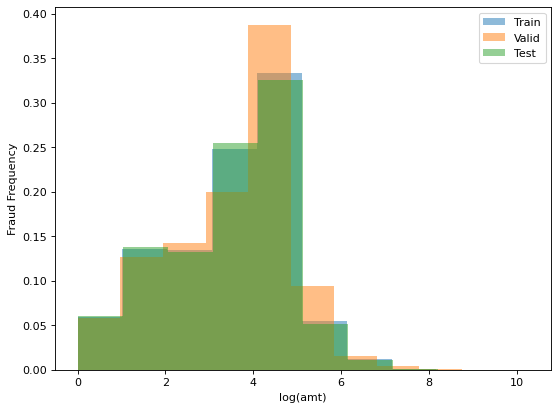

All samples (n = 1,852,394) accounted for.


In [22]:
#check to make sure all samples are accounted for and distribution of continous variable matches across data sets
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(train['Target'], alpha=0.5, label='Train',density=True)
plt.hist(valid['Target'], alpha=0.5, label='Valid',density=True)
plt.hist(test['Target'], alpha=0.5, label='Test',density=True)
plt.legend(loc='upper right')
plt.title = ('log(amt) Distribution in Split Datasets')
plt.xlabel('log(amt)')
plt.ylabel('Fraud Frequency')
plt.show()

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'

In [26]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

#check to make sure all samples are accounted for and prevelence of classification target variable matches across data sets
print('Target checks:')
print('Test prevalence(n = {:0,d}):{:.3f}'.format(len(test),calc_prevalence(test.Target.values)))
print('Valid prevalence(n = {:0,d}):{:.3f}'.format(len(valid),calc_prevalence(valid.Target.values)))
print('Train all prevalence(n = {:0,d}):{:.3f}'.format(len(train),calc_prevalence(train.Target.values)))

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'
print('For continous variables the prevelence is actually the average of the target variable')

Target checks:
Test prevalence(n = 277,859):3.454
Valid prevalence(n = 277,859):3.454
Train all prevalence(n = 1,296,676):3.456
All samples (n = 1,852,394) accounted for.
For continous variables the prevelence is actually the average of the target variable


In [27]:
#change data sets into maxtrix objects for the models
X_train = train[input_col].values
X_valid = valid[input_col].values
X_test = test[input_col].values

y_train = train['Target'].values
y_valid = valid['Target'].values
y_test = test['Target'].values